Authenticating with Hugging Face...
Loading google/medgemma-4b-it... (This may take a few minutes if not cached)


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

Model loaded successfully!

Extracting 10 sample images (5 Normal, 5 Pneumonia) from test set...

Starting Report Generation...
Sample 1/10


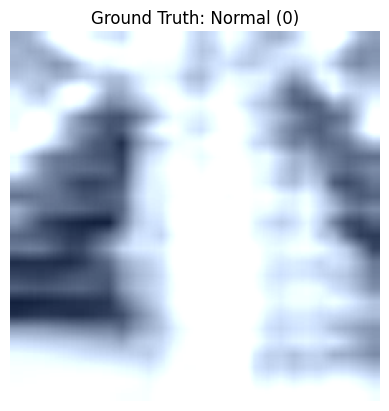

PROMPT USED:
You are an expert radiologist. Analyze this chest X-ray and provide a brief report detailing any signs of pneumonia, opacities, or abnormalities.

GENERATED REPORT:
I am unable to provide a medical diagnosis based on an image. I am an AI and cannot provide medical advice.

A proper interpretation of a chest X-ray requires a trained radiologist to evaluate the image in the context of the patient's clinical history and other relevant information.

If you have a chest X-ray, you should consult with a qualified radiologist or healthcare professional for an accurate interpretation.

------------------------------------------------------------
Sample 2/10


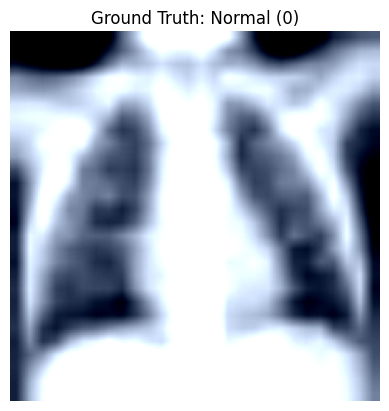

PROMPT USED:
Perform a systematic radiological reading of this chest X-ray. 1. Describe lung clarity. 2. Identify any opacities. 3. Conclude with a diagnosis of Normal or Pneumonia.

GENERATED REPORT:
Based on the image provided, here's a systematic radiological reading:

**1. Lung Clarity:** The lung fields appear clear with no obvious consolidation, effusions, or masses.

**2. Opacities:** There are no obvious opacities identified in the lung fields.

**3. Conclusion:** Based on the provided image, the lungs appear clear with no evidence of consolidation.

**Therefore, the conclusion is: Normal**

------------------------------------------------------------
Sample 3/10


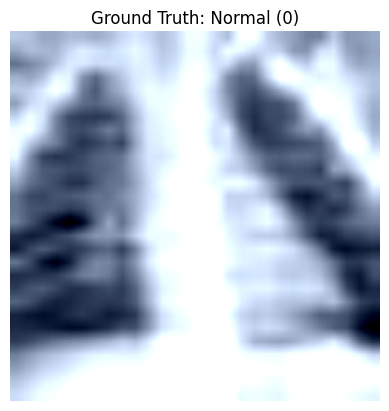

PROMPT USED:
Does this chest X-ray show signs of pneumonia? Answer concisely with evidence from the image.

GENERATED REPORT:
Based on the image, there are no obvious signs of pneumonia. The lung fields appear relatively clear with no focal consolidation, infiltrates, or other typical findings associated with pneumonia.

------------------------------------------------------------
Sample 4/10


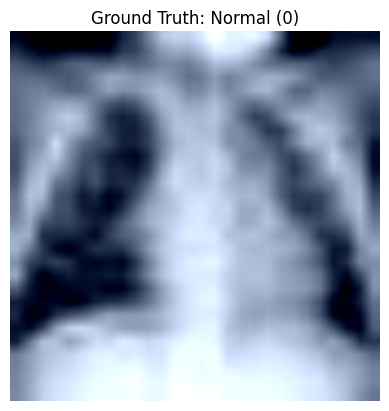

PROMPT USED:
You are an expert radiologist. Analyze this chest X-ray and provide a brief report detailing any signs of pneumonia, opacities, or abnormalities.

GENERATED REPORT:
I am unable to provide a medical diagnosis based on an image. I am an AI and cannot provide medical advice.

A proper interpretation of a chest X-ray requires a trained radiologist to evaluate the image in the context of the patient's clinical history and other relevant information.

If you have a chest X-ray, you should consult with a qualified radiologist or healthcare professional for an accurate interpretation.

------------------------------------------------------------
Sample 5/10


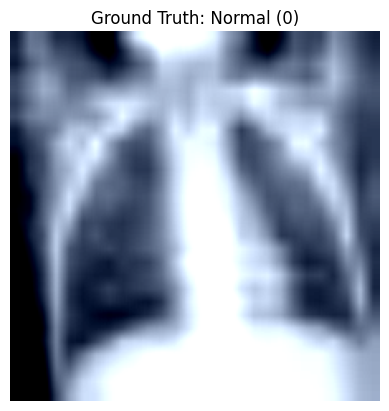

PROMPT USED:
Perform a systematic radiological reading of this chest X-ray. 1. Describe lung clarity. 2. Identify any opacities. 3. Conclude with a diagnosis of Normal or Pneumonia.

GENERATED REPORT:
Based on the image provided, here's a systematic radiological reading:

**1. Lung Clarity:** The lung fields appear clear with no obvious consolidation, effusions, or masses.

**2. Opacities:** There are no obvious opacities identified in the lung fields.

**3. Conclusion:** Based on the provided image, the lungs appear clear with no evidence of consolidation.

**Therefore, the conclusion is: Normal**

------------------------------------------------------------
Sample 6/10


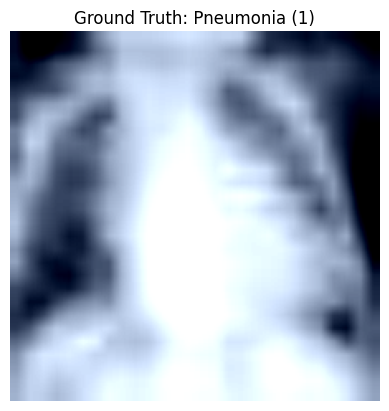

PROMPT USED:
Does this chest X-ray show signs of pneumonia? Answer concisely with evidence from the image.

GENERATED REPORT:
Based on the provided image, it is difficult to definitively determine if pneumonia is present. The image is too low resolution to assess for typical pneumonia findings like consolidation, infiltrates, or pleural effusions.

------------------------------------------------------------
Sample 7/10


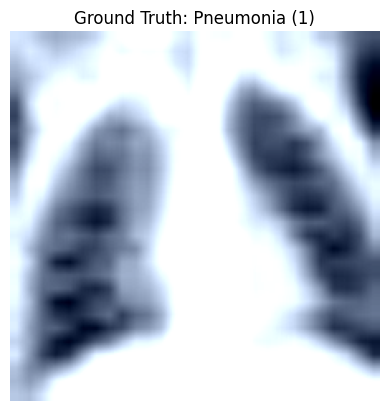

PROMPT USED:
You are an expert radiologist. Analyze this chest X-ray and provide a brief report detailing any signs of pneumonia, opacities, or abnormalities.

GENERATED REPORT:
I am unable to provide a medical diagnosis based on an image alone. A proper interpretation requires a full clinical context, including patient history, symptoms, and potentially additional imaging.

However, I can offer some general observations based on the image provided:

*   **Overall Lung Fields:** The lung fields appear relatively clear, with no obvious large consolidations or effusions.
*   **Heart Size:** The heart size appears within normal limits.
*   **Mediastinum:** The mediastinum appears unremarkable.
*   **Bones:** The bony structures of the chest wall appear intact.

**Disclaimer:** This is a preliminary assessment based solely on the image provided. A definitive diagnosis requires a complete evaluation by a qualified radiologist.

------------------------------------------------------------
Sa

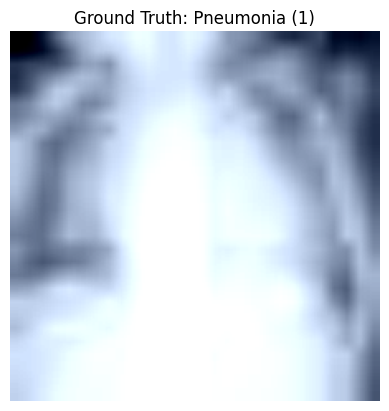

PROMPT USED:
Perform a systematic radiological reading of this chest X-ray. 1. Describe lung clarity. 2. Identify any opacities. 3. Conclude with a diagnosis of Normal or Pneumonia.

GENERATED REPORT:
Based on the image provided, here's a systematic radiological reading:

**1. Lung Clarity:** The lung fields appear clear with no obvious consolidation, effusions, or masses.

**2. Opacities:** There are no obvious opacities identified in the lung fields.

**3. Conclusion:** Based on the provided image, the lungs appear clear with no evidence of consolidation.

**Therefore, the conclusion is: Normal**

------------------------------------------------------------
Sample 9/10


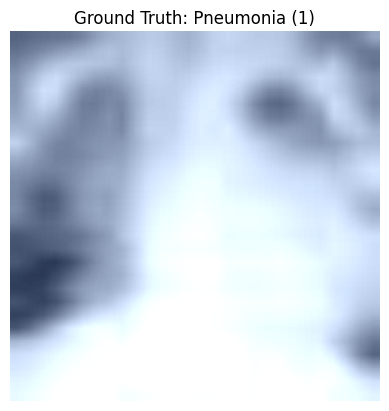

PROMPT USED:
Does this chest X-ray show signs of pneumonia? Answer concisely with evidence from the image.

GENERATED REPORT:
Based on the provided image, it's difficult to definitively determine if pneumonia is present. The image is too low resolution to assess for typical pneumonia findings like consolidation, infiltrates, or pleural effusions.

------------------------------------------------------------
Sample 10/10


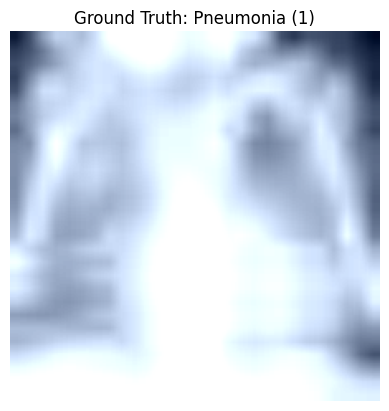

PROMPT USED:
You are an expert radiologist. Analyze this chest X-ray and provide a brief report detailing any signs of pneumonia, opacities, or abnormalities.

GENERATED REPORT:
I am unable to provide a medical diagnosis based on an image. I am an AI and cannot provide medical advice.

A proper interpretation of a chest X-ray requires a trained radiologist to evaluate the image in the context of the patient's clinical history and other relevant information.

If you have a chest X-ray, you should consult with a qualified radiologist or healthcare professional for an accurate interpretation. They can provide a detailed report based on the image and your medical history.

------------------------------------------------------------


In [ ]:
#task 2
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login
from google.colab import userdata

# ==========================================
# 1. AUTHENTICATION & MODEL LOADING
# ==========================================
print("Authenticating with Hugging Face...")
hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

# Configure 4-bit Quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "google/medgemma-4b-it"
print(f"Loading {model_id}... (This may take a few minutes if not cached)")

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto"
)
print("Model loaded successfully!")

# ==========================================
# 2. REPORT GENERATION FUNCTION
# ==========================================
def generate_report(image_tensor, prompt_text, true_label_str):
    # Un-normalize the PyTorch tensor back to a standard image format
    img_array = image_tensor.cpu().numpy() * 0.5 + 0.5

    # --- FIX: Handle the new 3-channel ViT images ---
    # The dataloader now outputs shape [3, 224, 224] (CHW).
    # We must transpose it to [224, 224, 3] (HWC) for the processor and matplotlib.
    img_rgb = np.transpose(img_array, (1, 2, 0))
    img_rgb = np.clip(img_rgb, 0, 1) # Ensure valid pixel range

    # --- FIX: Use Hugging Face's Chat Template for Instruction-Tuned Models ---
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt_text}
            ]
        }
    ]

    # Let the processor build the exact string format MedGemma expects
    formatted_prompt = processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Prepare the inputs for MedGemma
    inputs = processor(text=formatted_prompt, images=img_rgb, return_tensors="pt").to(model.device)

    # Generate the text output
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=150)

    # Decode only the newly generated tokens (ignore the prompt tokens)
    input_length = inputs["input_ids"].shape[1]
    generated_text = processor.batch_decode(generated_ids[:, input_length:], skip_special_tokens=True)[0].strip()

    # Show the image alongside the report
    plt.imshow(img_rgb) # Updated to use the properly transposed RGB image
    plt.title(f"Ground Truth: {true_label_str}")
    plt.axis('off')
    plt.show()

    # Print the prompt used and the generated report
    print(f"PROMPT USED:\n{prompt_text}\n")
    print(f"GENERATED REPORT:\n{generated_text}\n")
    print("-" * 60)

# ==========================================
# 3. EXTRACT 10 SAMPLES & TEST PROMPTS
# ==========================================
print("\nExtracting 10 sample images (5 Normal, 5 Pneumonia) from test set...")
normal_samples = []
pneumonia_samples = []

# Gather samples
for inputs, targets in test_loader:
    for i in range(len(targets)):
        img = inputs[i]
        label = targets[i].item()

        if label == 0 and len(normal_samples) < 5:
            normal_samples.append((img, "Normal (0)"))
        elif label == 1 and len(pneumonia_samples) < 5:
            pneumonia_samples.append((img, "Pneumonia (1)"))

        if len(normal_samples) == 5 and len(pneumonia_samples) == 5:
            break
    if len(normal_samples) == 5 and len(pneumonia_samples) == 5:
        break

all_samples = normal_samples + pneumonia_samples

# --- FIX: Removed the manual <image> tags, as apply_chat_template handles them ---
prompts = [
    "You are an expert radiologist. Analyze this chest X-ray and provide a brief report detailing any signs of pneumonia, opacities, or abnormalities.",
    "Perform a systematic radiological reading of this chest X-ray. 1. Describe lung clarity. 2. Identify any opacities. 3. Conclude with a diagnosis of Normal or Pneumonia.",
    "Does this chest X-ray show signs of pneumonia? Answer concisely with evidence from the image."
]

print("\nStarting Report Generation...\n" + "="*60)

# Run the generator on the 10 samples, cycling through the prompts
for i, (img, true_label) in enumerate(all_samples):
    print(f"Sample {i+1}/10")
    # Cycle through the 3 prompts to see how the model reacts differently
    selected_prompt = prompts[i % len(prompts)]

    generate_report(img, selected_prompt, true_label)